### Autores: **Angel David Piñeros Sierra**, **Camilo Andrés Roncancio Toca**, **Kelly Johana Solano Calderón**



---



## **Tarea 3 - Semantic Segmentation**





**Sobre las redes convolucionales (CNN):**

> *Convolucionar: Aplicar una "ventana deslizante" a una matriz de píxeles que representan a una imagen (Keita, 2024).*

Las redes convolucionales son ampliamente utilizadas para el procesamiento de imágenes, teniendo en cuenta sus propiedades y dimensiones. Este tipo de redes esta conformado por capas convolucionales que procesan regiones locales de las imágenes de forma independiente, utilizando parámetros que se comparten a lo largo de toda la imagen.

Se tienen en cuenta las siguientes propiedades y procesos:

*   La representación de una imagen se mantiene, así se le hayan aplicado transformaciones (ej: traslación).
*   El proceso de convolución se refiere a la transformación de un vector de entrada $x$ a un vector de salida $z$, donde cada elemento $z_i$ es la suman ponderada de las entradas cercanas a la posición $i$. Los mismos valores de los pesos se utilizan en cada posición del recorrido (esto se llama `convolution kernel` o `filtro`). El tamaño de las regiones se llama `kernel size`.
*   Padding permite añadir un margen en los bordes de las imágenes para evitar la reducción de tamaño en las convoluciones.
*   Stride (paso) permite evaluar cierta cantidad de pixeles según su tamaño de stride. Por ejemplo, si se quiere evaluar la salida de cada posición, se tendrá un `stride` de 1.
*   El `kernel size` permite modificar el tamaño del área de análisis de la imagen. Comúnmente se fija en un valor impar para centrar el área en la posición de análisis. Aumentar el tamaño puede ser contraproducente, ya que requiere de más pesos.
*   La `dilatación (dilatation)` refiere al proceso de aumentar la dimensionalidad del `kernel size` intercalando ceros. La cantidad de ceros que se agreguen definirá el `dilatation rate`.
*   Las capas convolucionales calculan su salida, realizando la convolución de los datos de entrada y su bias.
*   El `canal (channel)` permite aplicar varias convoluciones en paralelo, evitando así la pérdida de información. Este proceso produce varias variables ocultas llamadas `canales`.
*   Existen procesos para la manipular los datos, estos son `downsampling (submuestreo)` y el `upsampling (sobremuestreo)`. En el primer caso se busca reducir la resolución espación de datos 2D. Comúnmente las dimensiones espaciales en la red dismuyen de tamaño, mientras que el número de canales aumenta. En el segundo caso, se busca aumentar la resolución de una representación en los casos donde la salida de la red es una imagen (cómo es el caso de está tarea).

A partir de las nociones de redes convolucionales nace la aplicación de la segmentación semántica, la cual se enfoca en asignar una etiqueta o categoría a cada pixel de una imagen. Esta respectiva etiqueta indica a qué objeto pertenece el pixel y en caso contrario, no colocará etiqueta si no se encuentra dentro de la información de entrenamiento.

**Estructura codificador - decodificador**

Dentro de las redes convolucionales existe una estructura muy utilizada para el procesamiento de tareas relacionadas con imágenes llamada "Codificador-Decodificador". Se caracteriza porque las caracteristicas de las imágenes son extraidas en la etapa de codificación y luego son utilizadas para reconstruir las imágenes en el decodificador (Kainat, 2023).

***Fase de codificador***

En esta parte de la red, la CNN toma cada imagen de entrada para ir reduciendo sus dimensiones espaciales, mientras se incrementan el número de canales (o mapas de características). Este proceso se hace a través de las convoluciones y las capas de pooling. Cada capa convolucional va aplicando filtros a la imagen para capturar patrones. Estos filtros detectarán características como texturas, formas y demás. En cada avance, se tomarán características cada vez más abstractas de las imágenes.

***Espacio latente***

Es la salida del codificador y representa una versión comprimida o reducida de la imagen de entrada. En esta se encuentra la información más importante sobre la imagen de entrada. Las dimensiones de este espacio representan las diferentes características identificadas.

***Fase de decodificación***

En esta última parte de la red, la CNN toma la versión comprimida del espacio latente y la utiliza para generar una imagen de salida. El proceso que realiza consiste en muestrear gradualmente el espacio latente a través de capas convolucionales transpuestas. Estas capas aumentarán las dimensiones espaciales a medida que disminuyen el número de canales.

***¿Por qué esta arquitectura es importante?***

Esta arquitectura se implementa en tareas donde se requiere caracterizar las imágenes pixel por pixel (como es el caso de la segmentación semántica). Es por esta razón que se requiere un proceso adicional a la codificación, donde se consigue reducir la resolución, extraer las características más importantes, perdiendo detalles espaciales. Para llevar a tener una salida caracterizada como la que se desea, es necesario reconstruir dichos detalles espaciales de la codificación para llegar a la clasificación de cada píxel.


<img src="https://res.cloudinary.com/dlsntlruu/image/upload/v1763935720/etapas_cac_cancer_1_tkyypj.png" width="400px"/>

**Sobre las redes residuales**

Las redes convolucionales ofrecen una mejora considerable en el rendimiento de los modelos, sin embargo, a medida que se añaden más capas, el rendimiento en el entrenamiento decrece. Es por este motivo que se introducen las redes residuales, las cuales se basan en los *bloques residuales* y las *conexiones residuales (residual connetion)*.

El principio es el siguiente: en lugar de que cada capa aprenda una transformación del estado actual, solo debe aprender una adición o cambio en este. No obstante, aunque se mejora el entrenamiento, puede incrementar exponencialmente la varianza de las activaciones. Los bloques residuales entran a abordar el problema utilizando *Batch Normalization*, que permite re-escalar y re-centrar las activaciones de las capas.

***Conexiones de salto y conexiones residuales***

Son conexiones que permiten que la información de una capa "salte" a una o más capas que no son directamente adyacentes (Sivaram, 2025).

Dependiendo de la arquitectura que se este implementando (por ejemplo sea una ResNet o una U-Net), los beneficios varian:

*En el caso de las ResNet:*

*    Resuelve el problema del desvanecimiento del gradiente, dado que cuando las redes se vuelven cada vez más profundas, los gradientes pueden volverse muy pequeños (al multiplicarse por número muy pequeños). El gradiente en estas situaciones podría llegar a cero. El usar estas conexiones permie que los valores de gradiente de capas anteriores puedan "fluir" más facilmente en otras regiones de la red. En resumen, da una mayor estabilidad en este tipo de redes.
*    Facilita el entrenamiento de las redes que son muy profundas, porque cada bloque residual aprende los residuos, que son las diferencias entre las entradas y salidas, o en notación $y = F(x) + x$, donde $x$ es la entrada del bloque original, $F(x)$ es la transformación hecha en el bloque (por ejemplo, una convolución) y $y$ la suma de estos dos valores.

*En el caso de la U-Net*

*    Estas conexiones permiten conectar capas de las parte de codificación a la parte de decodificación. Esto se hace con el fin de detalles aprendidos en la codificación se puedan utilizar para construir la imagen de salida de la decodificación.
*    Permiten que en la decodificación se restauren detalles precisos de la imagen como los bordes, las texturas.
*    En este caso concreto, las skip connection no obtienen los residuos, sino solo permiten concatenar las capas.

Algo importante a tener en cuenta en nuestra implementación es que existe una diferencia entre lo que se considera como conexión de salto y conexión residual.

Concretamente,

*   Ambas permiten (en cierta medida) un mejor flujo de los gradientes entre las capas.                         
*   Directamente concatenan las características encontradas en las capas.
*   Añaden la entrada original a la salida de una capa para mejorar la propagación del gradiente.




**La arquitectura U-Net**




La arquitectura U-Net implementa una estructura codificador-decodificador que permite, a través de varias capas convolucionales, reducir la resolución de la imagen, para recolectar la mayor información de cada región de la imagen, llendo de lo más específico a lo más general. Luego, el decodificador toma esta salida como su entrada para volver a remuestrear la imagen según las propiedades recolectadas por el codificador.
La salida del codificador son las probabilidades sobre las clases, de cada píxel.


<img src="https://res.cloudinary.com/dlsntlruu/image/upload/v1764101709/unet_niibbg.png" width="700px"/>

Su estructura consiste en:

*    Parte izquierda que *contrae*.
*    Parte derecha que *explande*.
*    La parte izquierda tiene la arquitectura de una red convolucional, la cual aplica dos convoluciones $3 \times 3$. Para la versión de la U-Net original, NO se aplica padding.
*    Cada convolución de la parte izquierda, esta seguida por una función de activación ReLU y una operación de *max pooling* $2 \times 2$, con stride de $2$ para hacer el submuestreo.
*   Cada vez que se hace el submuestreo, el número de canales se duplica.
*    La parte derecha sobremuestrea el mapa de caracteristicas por convoluciones que explanden $2 \times 2$. A su vez, este proceso reduce el número de canales a la mitad.
*    En la última capa se utiliza una convolución $1 \times 1$ que mapea el vector de caracteristicas, según el número de clases.
*    Hay 23 capas convolucionales.
*    Se recomienda usar tamaños de capa pares, para aplicar el max-pooling $2 \times 2$.

El proceso de entrenamiento de este tipo de red se hace con gradiente descendiente estocástico. Se pueden utilizar fragmentos de entrada grandes para minimizar la sobrecarga de GPU. Acá el lote que se procesa será de una sola imagen.

También se aconseja usar un momentum alto de $0.99$ para que el procesamiento previo pueda influir en la decisión del paso actual. En el caso de la función de pérdida, se combinan dos estrategias, *cross entropy con soft-max* a nivel de píxel y *weighted loss* a nivel del mapa de pesos. Finalmente, se tiene en cuenta que la inicialización de los pesos esta pensada para que exista una varianza unitaria (para que los pesos se adapten a los mapas de caracteristicas). Esto se logra usando una distribución Gaussiana con desviación estándar de $\sqrt{2/N}$.






### **Bibliografía**

Kainat. (2023, agosto 12). Encoder-Decoder: Features Extraction. Medium.com. https://medium.com/@kitkat73275/encoder-decoder-features-extraction-fbccfc31c047

Keita, Z. (2024, abril 15). Introducción a las redes neuronales convolucionales (CNN). Datacamp.com. https://www.datacamp.com/es/tutorial/introduction-to-convolutional-neural-networks-cnns

Sivaram. (2025, mayo 1). Mastering residual connections: Enhancing neural networks for optimal performance - LUNARTECH. Lunartech.Ai. https://www.lunartech.ai/blog/mastering-residual-connections-enhancing-neural-networks-for-optimal-performance

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. En arXiv [cs.CV]. https://doi.org/10.48550/ARXIV.1505.04597




## **Modelo a implementar para la segmentación semántica de enfermedades en hoja de café**

### **Arquitectura implementada**

Para realizar la segmentación semántica de enfermedades en hojas de café, se implementará una red convolucional bajo la arquitectura U-Net explicada previamente. En esta se incluye el uso de bloques residuales dentro de cada bloque de convolución, lo cual añadirá las entradas al resultado de la función de activación. También se incluyen conexiones de paso para conectar las salidas de los bloques convolucionales de codificación, con las entradas de los bloques convolucionales de decodificación. Se plantea tener la siguiente estructura:

<img src="https://res.cloudinary.com/dlsntlruu/image/upload/v1764299782/arquitectura_res_unet_fcefyw.png"/>

**Estrategias de tratamiento de datos**
*    Reescalamiento de de las imágenes y máscaras a un tamaño fijo de píxeles. Se utilizará un `TARGET_SIZE=(256, 256)`. Esto se hace con el propósito de trabajar con imágenes que tengan una dimensión en potencia de 2 (que es lo recomendado según las redes U-Net).
*    Normalización: Cada píxel de entrada se escalará del rango de $[0, 255]$ a un rango de $[0, 1]$. Esto se hace con la transformación `ToTensor()`. Acá se busca que los valores de entrada estén en un rango adecuado que evite que los gradientes se vuelvan muy grandes durante el entrenamiento.
*    Estandarización: Como se realizan procesos de reescalamiento, es necesario ajustar la distribución de los datos.
*    División del dataset: Se tienen en cuenta que el dataset se conforma de dos conjuntos: entrenamiento y testing. Vamos a tomar del conjunto de entrenamiento y lo vamos a tomar un $15\%$ para crear un conjunto de validación.
*    Aumento de datos para el entrenamiento y la validación. Se aplican ajustes de color para diferentes parámetros como el brillo, el contraste y la saturación. También se aplica Blur (que es un desenfoque) en una probabilidad de $30%$ y ruido gaussiano (que es agregarle granularidad). Finalmente se agregan aumentos geométrico como rotaciones, volteos verticales (con $50\%$ de probabilidad) y traslaciones y zoom ligeros.
*    Mapeo de las máscaras RGB a clases discretas, donde $0$ será para el fondo, $1$ para la parte sana de la hoja y $3$ para identificar la enfermedad.

**Optimizador**

Se utilizará Gradiente Descendiente Estocástico (SGD) con la siguiente configuración:

*   Learning rate: $0.0005$
*   Momentum: $0.9$

Estos valores con los más recomendados según el paper guía de la U-Net.

**Descripción de hiperparámetros**

Se definieron los siguientes hiperparámetros para configurar la red:

*   `TARGET_SIZE: (256, 256)` Para definir un tamaño fijo en las imágenes y las máscaras.
*   `NOISE_STD: 0.01` Para definir la desviación estándar que tomará la función que agrega ruido gaussiano a las imágenes.
*   `val_fraction: 0.15` Para definir el porcentaje de imágenes y máscaras que se tomarán de *train* para crear el conjunto *validation*.
*   `batch_size: 4` Para procesar solo 4 muestras en cada iteración en la etapa de entrenamiento.
*   `seed: 42` Para definir el valor de aleatoriedad y se puedan reproducir los resultados.
*   `n_channels: 3` Porque las imagenes manejan 3 canales de entrada, que son los RGB.
*   `n_classes: 3` Habrán tres clases de salida para la segmentación, el fondo, la parte sana y la parte enferma.
*   `kernel_size: 3` En las capas convolucionales, el tamaño del kernel será de $3 \times 3$.
*   `padding: 1` Se añade un padding de 1 para dar un margen pequeño al mapa de características y para que se mantengan las dimensiones espaciales entre los mapas de entrada y salida.
*   `kernel_size: 1` En la capa de salida el tamaño de kernel cambia a $1 \times 1$, para obtener en la salida los 3 canales finales.
*   `kernel_size: 2 y stride: 2` Para la parte de pooling, la ventana será más pequeña, en este caso de $2 \times 2$ y se moverá cada $2$ píxeles. Estos mismos valores también se pone en la parte de la convolución transpuesta para la parte de "desconvolucionar", pero en lugar de reducir en a la mitad, va a duplicar las dimensiones.
*    En las capas del codicador se definió que los mapas de características tuvieran estos tamaños: $64$, $128$, $256$, $512$, $1024$.
*    En las capas del decodificador se definió que los mapas tuvieran estos tamaños: $512$, $256$, $128$ y $64$.
*   `num_epochs: 100` Se utilizarán 100 épocas en entrenamiento.
*   `learning_rate: 0.0005` Que será la tasa de aprendizaje del optimizador.
*   `momentum: 0.9` Que es el valor del momentum para el optimizador.
*   `criterion: nn.CrossEntropyLoss()` Para definir la función de pérdida a usar, que es Cross Entropy.  

Importación del dataset de hojas de café

In [ ]:
!pip install gdown
id_gdrive = "1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF"
nombre_archivo = "coffee_leaves.7z"
!gdown --id $id_gdrive --output $nombre_archivo

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF
To: /content/coffee_leaves.7z
100% 58.7M/58.7M [00:00<00:00, 181MB/s]


Importación de librerías

In [ ]:
%pip install gdown py7zr pillow torch torchvision matplotlib pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from pathlib import Path
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt

Se genera la siguiente función para descomprimir el dataset

In [ ]:
import py7zr
import os

def descomprimir_archivo(archivo):
    if os.path.exists(archivo[:-3]):
        return
    with py7zr.SevenZipFile(archivo, mode='r') as z:
         z.extractall(path=archivo[:-3])

descomprimir_archivo('coffee_leaves.7z')

### **Tratamiento de datos**

Para realizar el tratamiento de los datos, se utilizarán inicialmente dos estrategias:

1) Normalización: En este proceso se busca ajustar todos los datos en una escala común. Concretamente, se escalarán los píxeles de cada imagen (sabemos que son 3 canales, cada uno de 8 bits, por lo tanto cada canal tiene 255 posibles valores). Estos valores son muy grandes, entonces lo más conveniente para evitar posibles gradientes muy grandes, es pasar estos valores en un rango de $[0-1]$ utilizando la función de ToTensor().
2) Estandarización: Como se realizó el proceso de normalización y ahora los datos están en un rango distinto, es necesario asegurar que la distribución de esos datos este centrada en cero y la escala de los datos sean uniformes (en este caso, con una desviación estándar de 1).

El escalamiento se hace canal por canal (RGB en este caso), al calcular la media por canal y su desviación estándar.

In [ ]:
# Normalización y estandarización de las imágenes de ENTRADA usando estadísticas del propio dataset
# 1) Reescalamos todas las imágenes a un tamaño fijo (potencia de 2)
# 2) ToTensor() normaliza los píxeles de [0, 255] a [0, 1]
# 3) Calculamos media y desviación estándar por canal SOBRE esas imágenes normalizadas
# 4) Usamos esos valores en transforms.Normalize para estandarizar: (x - mean) / std

train_imgs_dir = os.path.join("coffee_leaves", "coffee_leaves", "train", "imgs")
img_filenames = [f for f in os.listdir(train_imgs_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Tamaño objetivo (potencia de 2) para U-Net
TARGET_SIZE = (256, 256)
resize_transform = transforms.Resize(TARGET_SIZE)
mask_resize_transform = transforms.Resize(TARGET_SIZE, interpolation=InterpolationMode.NEAREST)

means = []
stds = []

for fname in img_filenames:
    img_path = os.path.join(train_imgs_dir, fname)
    img = Image.open(img_path).convert("RGB")
    # 1) Reescalamiento de la imagen
    img_resized = resize_transform(img)
    # 2) Normalización: [0, 255] -> [0, 1]
    img_tensor = transforms.ToTensor()(img_resized)
    # media y desviación estándar POR CANAL
    means.append(img_tensor.mean(dim=(1, 2)))
    stds.append(img_tensor.std(dim=(1, 2)))

means = torch.stack(means, dim=0)
stds = torch.stack(stds, dim=0)

# 3) Estadísticos finales del dataset (promedio sobre todas las imágenes)
IMG_MEAN = means.mean(dim=0)
IMG_STD = stds.mean(dim=0)

print("Media por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_MEAN)
print("Desviación estándar por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_STD)




Por otro lado, como se busca que el modelo generalice la segmentación y no memorice lo que se vaya a entrenar, se realiza un proceso de *data augmentation*. Es decir, se busca incrementar la diversidad de las muestras de entrenamiento, en lugar de requerir tomar nuevas imágenes de hojas.

Si el modelo se encuentra en modo "training" (entrenamiento) se generan variaciones a la imágenes como:

*    Ajustes de color (brillo, contraste, saturación y de tono).
*    Blur.
*    Ruido gaussinado o granularidad.
*    Rotaciones.
*    Zooms.
*    Flips verticales.

Mientras que si el modelo esta en modo "validation" (validación) se generan otras modificaciones:
*    Rescalamiento.
*    Normalización.

Esto es útil para evitar el overfitting que puede causar tener imágenes que fueron tomadas con iguales condiciones. Cuando ingresen nuevas imágenes, el modelo puede generalizar las condiciones.

In [ ]:

# Utilidades de aumento de datos (para imagen y máscara)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05)
blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
normalize_transform = transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist())
NOISE_STD = 0.01

"""
    Adición de ruido gaussiano suave sobre tensores ya normalizados a [0, 1].
"""
def add_gaussian_noise(tensor, std=NOISE_STD):
    if std <= 0:
        return tensor
    noisy_tensor = tensor + std * torch.randn_like(tensor)
    return torch.clamp(noisy_tensor, 0.0, 1.0)

"""
    Aplicación de rotaciones suaves, flips verticales y zooms ligeros a imagen y máscara.
"""
def apply_geometric_augmentations(img, mask):
    angle = random.uniform(-15.0, 15.0)
    img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR, fill=0)
    mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST, fill=0)

    flipped = random.random() < 0.5
    if flipped:
        img = TF.vflip(img)
        mask = TF.vflip(mask)

    max_dx = 0.02 * TARGET_SIZE[1]
    max_dy = 0.02 * TARGET_SIZE[0]
    translate = (
        random.uniform(-max_dx, max_dx),
        random.uniform(-max_dy, max_dy),
    )
    scale = random.uniform(0.9, 1.05)

    img = TF.affine(
        img,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.BILINEAR,
        fill=0,
    )
    mask = TF.affine(
        mask,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.NEAREST,
        fill=0,
    )

    metadata = {
        "rotation_deg": angle,
        "vertical_flip": flipped,
        "translate_px": translate,
        "scale_factor": scale,
    }
    return img, mask, metadata

COLOR_TO_CLASS = {
    (0, 0, 0): 0,      # fondo
    (0, 176, 0): 1,    # hoja sana
    (255, 0, 0): 2,    # mancha / enfermedad
}

"""
    Funciones para convertir la máscara RGB original en etiquetas discretas
    por píxel.
"""
def mask_to_tensor(mask):
    mask_rgb = np.array(mask.convert("RGB"))
    class_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for color, cls in COLOR_TO_CLASS.items():
        matches = np.all(mask_rgb == color, axis=-1)
        class_mask[matches] = cls
    return torch.from_numpy(class_mask).long()

"""
    Pipeline de entrenamiento: reescala, aplica geometría y variaciones
    fotométricas.
"""
def preprocess_training_sample(img, mask, return_metadata=False):
    metadata = {}
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img, mask, geom_metadata = apply_geometric_augmentations(img, mask)
    metadata.update(geom_metadata)

    img = color_jitter(img)
    metadata["color_jitter"] = True

    blur_applied = random.random() < 0.3
    metadata["blur_applied"] = blur_applied
    if blur_applied:
        img = blur_transform(img)

    img = transforms.ToTensor()(img)
    img = add_gaussian_noise(img, std=NOISE_STD)
    metadata["noise_std"] = NOISE_STD
    img = normalize_transform(img)

    mask = mask_to_tensor(mask)
    if return_metadata:
        return img, mask, metadata
    return img, mask

"""
    Transformaciones determinísticas para validación.
"""
def preprocess_validation_sample(img, mask):
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img = transforms.ToTensor()(img)
    img = normalize_transform(img)
    mask = mask_to_tensor(mask)
    return img, mask



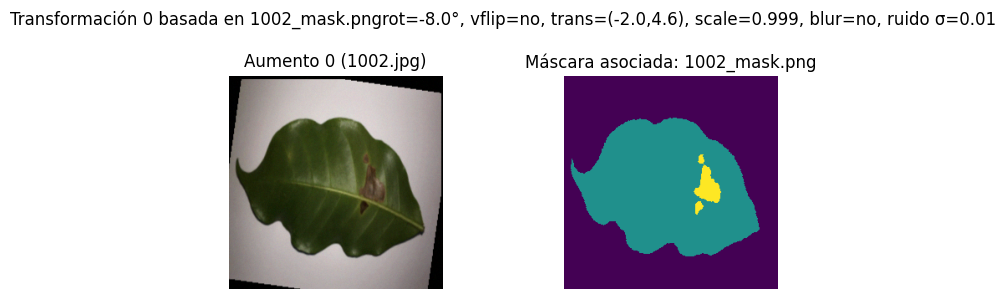

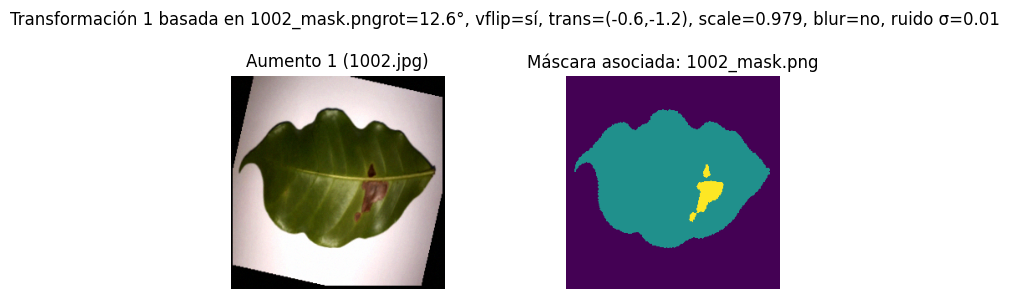

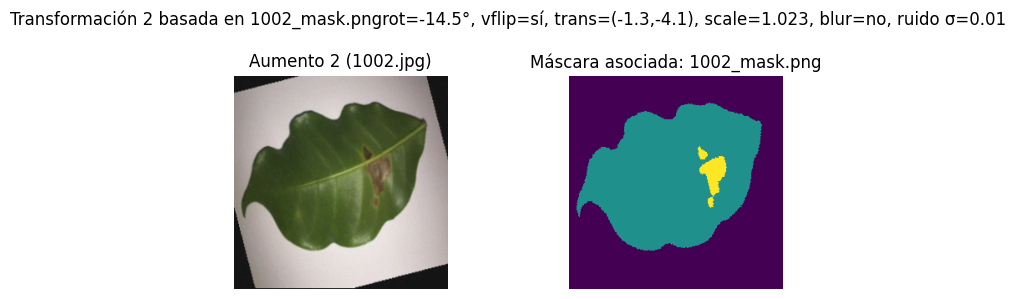

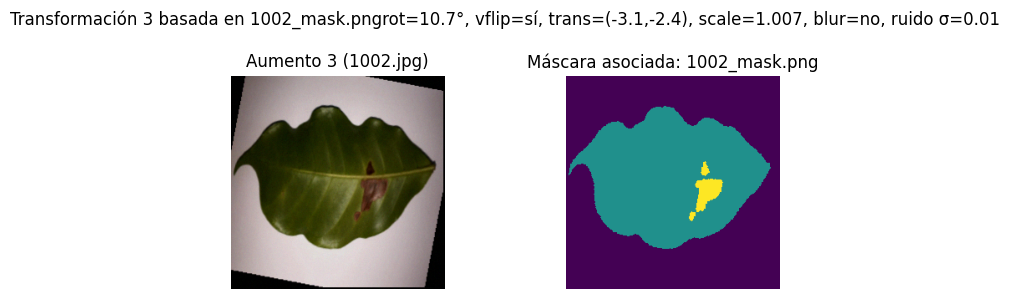

In [ ]:
1002
sample_img_path = "coffee_leaves/coffee_leaves/train/imgs/1002.jpg"
sample_mask_path = "coffee_leaves/coffee_leaves/train/masks/1002_mask.png"

sample_img = Image.open(sample_img_path).convert("RGB")
sample_mask = Image.open(sample_mask_path)

img_name = os.path.basename(sample_img_path)
mask_name = os.path.basename(sample_mask_path)

for i in range(4):
    img_t, mask_t, metadata = preprocess_training_sample(
        sample_img.copy(), sample_mask.copy(), return_metadata=True
    )

    geom = (
        f"rot={metadata['rotation_deg']:.1f}°, vflip={'sí' if metadata['vertical_flip'] else 'no'}, "
        f"trans=({metadata['translate_px'][0]:.1f},{metadata['translate_px'][1]:.1f}), "
        f"scale={metadata['scale_factor']:.3f}"
    )
    blur_txt = 'sí' if metadata['blur_applied'] else 'no'

    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    axes[0].imshow(img_t.permute(1, 2, 0).cpu().numpy() * IMG_STD.numpy() + IMG_MEAN.numpy())
    axes[0].set_title(f"Aumento {i} ({img_name})")
    axes[0].axis('off')

    axes[1].imshow(mask_t.cpu().numpy(), vmin=0, vmax=2, cmap='viridis')
    axes[1].set_title(f"Máscara asociada: {mask_name}")
    axes[1].axis('off')

    fig.suptitle(f"Transformación {i} basada en {mask_name}"f"{geom}, blur={blur_txt}, ruido σ={metadata['noise_std']}"
    )
    plt.tight_layout()
    plt.show()



In [ ]:
sample_mask_path = "coffee_leaves/coffee_leaves/train/masks/1002_mask.png"
mask_tensor = mask_to_tensor(Image.open(sample_mask_path))
print("Ruta de máscara:", sample_mask_path)
print("dtype:", mask_tensor.dtype)
print("Valores únicos:", mask_tensor.unique())

Ruta de máscara: coffee_leaves/coffee_leaves/train/masks/1002_mask.png
dtype: torch.int64
Valores únicos: tensor([0, 1, 2])


In [ ]:
# Dataset y DataLoaders para train/val/test
class CoffeeLeavesDataset(Dataset):
    def __init__(self, root_dir, filenames=None, mode='train'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'imgs')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.mode = mode

        all_imgs = sorted([
            f for f in os.listdir(self.img_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        if filenames is None:
            filenames = all_imgs
        self.filenames = filenames

        self.has_masks = os.path.isdir(self.mask_dir)
        if self.has_masks:
            mask_candidates = [
                os.path.join(self.mask_dir, os.path.splitext(name)[0] + '_mask.png')
                for name in self.filenames
            ]
            missing = [mp for mp in mask_candidates if not os.path.exists(mp)]
            if missing:
                raise FileNotFoundError(f"No se encontraron mascaras para: {missing[:3]}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')

        if not self.has_masks:
            img = resize_transform(img)
            img = transforms.ToTensor()(img)
            img = normalize_transform(img)
            return img, img_path

        mask_name = os.path.splitext(img_name)[0] + '_mask.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = Image.open(mask_path)

        if self.mode == 'train':
            img_t, mask_t = preprocess_training_sample(img, mask)
        else:
            img_t, mask_t = preprocess_validation_sample(img, mask)
        return img_t, mask_t

def build_dataloaders(train_root, test_root, val_fraction=0.15, batch_size=4, seed=42):
    rng = random.Random(seed)
    img_dir = os.path.join(train_root, 'imgs')
    all_files = sorted([
        f for f in os.listdir(img_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    rng.shuffle(all_files)
    val_count = max(1, int(len(all_files) * val_fraction))
    val_files = all_files[:val_count]
    train_files = all_files[val_count:]

    train_dataset = CoffeeLeavesDataset(train_root, filenames=train_files, mode='train')
    val_dataset = CoffeeLeavesDataset(train_root, filenames=val_files, mode='val')
    test_dataset = CoffeeLeavesDataset(test_root, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

TRAIN_ROOT = os.path.join('coffee_leaves', 'coffee_leaves', 'train')
TEST_ROOT = os.path.join('coffee_leaves', 'coffee_leaves', 'test')

train_loader, val_loader, test_loader = build_dataloaders(
    TRAIN_ROOT,
    TEST_ROOT,
    val_fraction=0.15,
    batch_size=4,
)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")



Train samples: 340
Val samples: 60
Test samples: 100


In [ ]:
# ------------------------------------------------------------
#   BLOQUE RESIDUAL (reemplaza DoubleConv)
# ------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # conexión residual (proyección si cambia # canales)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out = out + identity
        return F.relu(out)


# ------------------------------------------------------------
#                       ENCODER
# ------------------------------------------------------------
class Down(nn.Module):
    """MaxPool + ResidualBlock."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #Recordemos que el MaxPool reduce las dimensiones espaciales, en este caso  toma bloques 4x4
        # (vease que el kernel_size=2) y para que salte al siguiente bloque de 2x2, el stride=2.
        #  así, cada vez que bajamos de nivel en el encoder, reducimos a la mitad las dimensiones espaciales
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Recordemos tambien que el bloque residual block aumenta el número de canales de entrada a salida
        self.resblock = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.resblock(x)
        return x


# ------------------------------------------------------------
#                       DECODER
# ------------------------------------------------------------
class Up(nn.Module):
    """TransposedConv + concat + ResidualBlock."""
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # upsampling reduce canales a la mitad y duplica tamaño espacial
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        # después del concat tendrás: (in_channels)
        self.resblock = ResidualBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 viene del nivel inferior (decoder)
        x1 = self.up(x1)

        # ajustar tamaños por si hay desajustes leves
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

        # skip-connection por concatenación
        x = torch.cat([x2, x1], dim=1)

        return self.resblock(x)


# ------------------------------------------------------------
#                    SALIDA FINAL
# ------------------------------------------------------------
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# ------------------------------------------------------------
#                 U-NET CON RESIDUAL CONNECTIONS
# ------------------------------------------------------------
class ResUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()

        # encoder
        self.inc   = ResidualBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # decoder
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        # salida
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # ENCODER
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # DECODER
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        # SALIDA
        return self.outc(x)


# ------------------------------------------------------------
#  MÉTRICAS
# ------------------------------------------------------------


def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Métricas

En segmentación semántica el objetivo es asignar una clase a cada píxel de la imagen. Para evaluar la calidad del modelo se utilizan métricas que comparan la máscara predicha con la máscara real, midiendo exactitud, coincidencia espacial y solapamiento entre regiones.

#### Pixel Accuracy

La métrica Pixel Accuracy mide la proporción de píxeles correctamente clasificados respecto al total. Es una medida global del desempeño del modelo, pero puede ser poco informativa cuando el dataset está desbalanceado porque las clases mayoritarias dominan el resultado. En este caso la clase que más dominaria es la clase de Fondo, porque respecto a la clase que nos indica la lesión, por ejemplo, tiene menos pixeles

$p_i$ la clase predicha para el píxel $i$, $t_i$ la clase verdadera y $N$ el número total de píxeles:

$
\text{Pixel Accuracy} = \frac{\sum_{i=1}^{N} \mathbf{1}(p_i = t_i)}{N}
$


#### Indice Jaccard

El índice de Jaccard, en el contexto de segmentación semántica, es equivalente al IoU. Representa la misma razón entre la intersección y la unión de las máscaras predicha y real. Se utiliza en algunas áreas por tradición matemática, pero su interpretación es idéntica a la de IoU.

$
\text{Jaccard}_c = \frac{|A \cap B|}{|A \cup B|}
$

---

El coeficiente Dice es una medida de similitud entre la máscara predicha y la real. Es más tolerante que IoU en regiones pequeñas, por lo que resulta útil en problemas donde algunas clases ocupan pocos píxeles. Puede interpretarse como una versión del F1-score aplicada a segmentación.

Para una clase \(c\), con \(A\) la máscara predicha y \(B\) la máscara verdadera:

$
\text{Dice_c} = \frac{2|A \cap B|}{|A| + |B|}
$

También puede escribirse en términos de verdaderos positivos (TP), falsos positivos (FP) y falsos negativos (FN):

$
\text{Dice}_c = \frac{2TP}{2TP + FP + FN}
$

El promedio por clase se obtiene como:

$
\text{Dice Promedio} = \frac{1}{C} \sum_{c=1}^{C} \text{Dice}_c
$

---

In [ ]:
def pixel_accuracy(preds, targets):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == targets).float().sum()
    total = torch.numel(targets)
    return (correct / total).item()


def compute_jaccard(preds, targets, num_classes=3, eps=1e-6):
    """Jaccard promedio por clase (equivale a IoU)."""
    preds = torch.argmax(preds, dim=1)
    scores = []

    for cls in range(num_classes):
        pred_cls = preds == cls
        target_cls = targets == cls

        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()

        if union == 0:
            continue

        scores.append((intersection + eps) / (union + eps))

    if not scores:
        return 0.0

    return torch.stack(scores).mean().item()

def compute_dice(preds, targets, num_classes=3, eps=1e-6):
    preds = torch.argmax(preds, dim=1)
    scores = []

    for cls in range(num_classes):
        pred_cls = preds == cls
        target_cls = targets == cls

        intersection = (pred_cls & target_cls).float().sum()
        pred_sum = pred_cls.float().sum()
        target_sum = target_cls.float().sum()

        denom = pred_sum + target_sum
        if denom == 0:
            continue

        scores.append((2 * intersection + eps) / (denom + eps))

    if not scores:
        return 0.0

    return torch.stack(scores).mean().item()


Epoch 001/10 | train_loss=0.2931 | val_loss=0.1207 | train_jaccard=0.6163 | val_jaccard=0.6403 | train_dice=0.6404 | val_dice=0.6551 | train_pix_acc=0.9547 | val_pix_acc=0.9759 | time=27.4s
  -> Nuevo mejor modelo guardado en checkpoints/resunet_gsd_lr5e4.pt
Epoch 002/10 | train_loss=0.1034 | val_loss=0.0809 | train_jaccard=0.6556 | val_jaccard=0.6903 | train_dice=0.6794 | val_dice=0.7290 | train_pix_acc=0.9783 | val_pix_acc=0.9801 | time=28.8s
  -> Nuevo mejor modelo guardado en checkpoints/resunet_gsd_lr5e4.pt
Epoch 003/10 | train_loss=0.0767 | val_loss=0.0610 | train_jaccard=0.7054 | val_jaccard=0.7627 | train_dice=0.7520 | val_dice=0.8204 | train_pix_acc=0.9823 | val_pix_acc=0.9839 | time=27.8s
  -> Nuevo mejor modelo guardado en checkpoints/resunet_gsd_lr5e4.pt
Epoch 004/10 | train_loss=0.0638 | val_loss=0.0538 | train_jaccard=0.7573 | val_jaccard=0.7815 | train_dice=0.8144 | val_dice=0.8395 | train_pix_acc=0.9843 | val_pix_acc=0.9853 | time=27.2s
  -> Nuevo mejor modelo guardado 

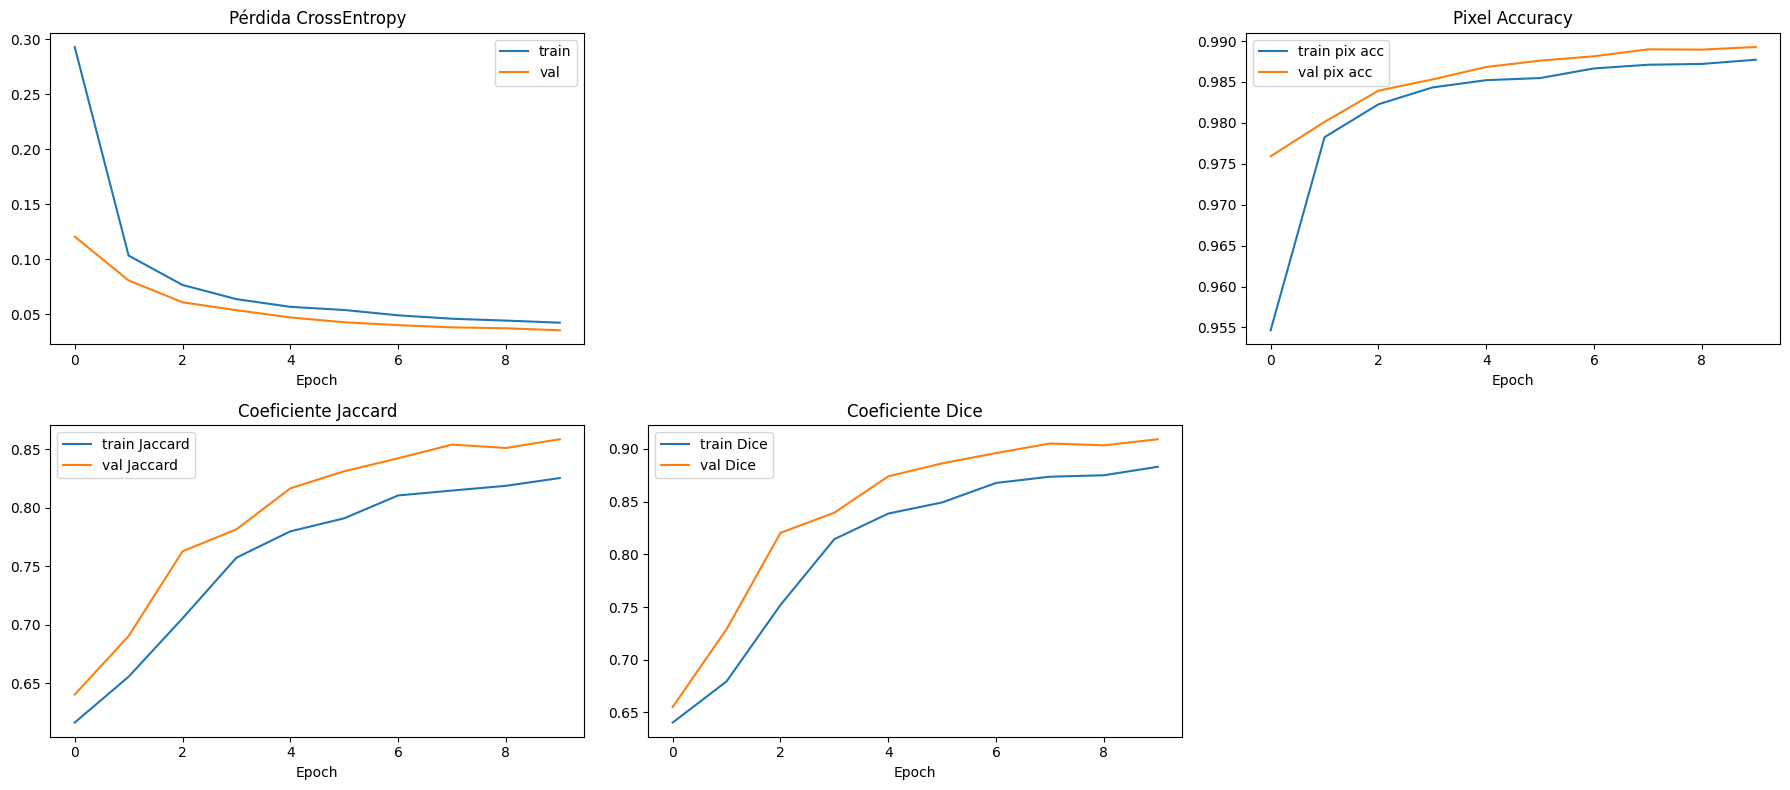

In [ ]:
num_epochs = 10
learning_rate = 5e-4
num_classes = 3
patience = 2   # Nueva variable para early stopping

device = get_device()
torch.backends.cudnn.benchmark = True
model = ResUNet(n_channels=3, n_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
history = {
    'train_loss': [],
    'val_loss': [],
    'train_jaccard': [],
    'val_jaccard': [],
    'train_dice': [],
    'val_dice': [],
    'train_acc': [],
    'val_acc': [],
}

best_val_jaccard = 0.0 # Cambiado de best_val_iou
epochs_no_improve = 0 # Contador para early stopping
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_path = checkpoint_dir / 'resunet_gsd_lr5e4.pt'

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    running_jaccard = 0.0
    running_dice = 0.0
    running_acc = 0.0
    sample_count = 0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        sample_count += batch_size
        running_loss += loss.item() * batch_size
        running_jaccard += compute_jaccard(logits.detach(), masks, num_classes=num_classes)
        running_dice += compute_dice(logits.detach(), masks, num_classes=num_classes)
        running_acc += pixel_accuracy(logits.detach(), masks)

    train_loss = running_loss / sample_count
    train_jaccard = running_jaccard / len(train_loader)
    train_dice = running_dice / len(train_loader)
    train_acc = running_acc / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0
    val_acc = 0.0
    val_samples = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)

            batch_size = imgs.size(0)
            val_samples += batch_size
            val_loss += loss.item() * batch_size
            val_jaccard += compute_jaccard(logits, masks, num_classes=num_classes)
            val_dice += compute_dice(logits, masks, num_classes=num_classes)
            val_acc += pixel_accuracy(logits, masks)

    val_loss = val_loss / val_samples
    val_jaccard = val_jaccard / len(val_loader)
    val_dice = val_dice / len(val_loader)
    val_acc = val_acc / len(val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_jaccard'].append(train_jaccard)
    history['val_jaccard'].append(val_jaccard)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)


    epoch_time = time.time() - epoch_start
    print(
        f"Epoch {epoch:03d}/{num_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | train_jaccard={train_jaccard:.4f} | val_jaccard={val_jaccard:.4f} | train_dice={train_dice:.4f} | val_dice={val_dice:.4f} | train_pix_acc={train_acc:.4f} | val_pix_acc={val_acc:.4f} | time={epoch_time:.1f}s"
    )

    if val_jaccard > best_val_jaccard: # Cambiado de val_iou a val_jaccard
        best_val_jaccard = val_jaccard # Cambiado de val_iou a val_jaccard
        epochs_no_improve = 0  # Reiniciar contador de paciencia
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_jaccard': val_jaccard, # Cambiado de val_iou a val_jaccard
            'history': history,
        }, checkpoint_path)
        print(f"  -> Nuevo mejor modelo guardado en {checkpoint_path}")
    else:
        epochs_no_improve += 1 # Incrementar contador de paciencia
        print(f"  -> No se mejoró Jaccard de validación. Paciencia: {epochs_no_improve}/{patience}") # Mensaje actualizado

    if epochs_no_improve >= patience:
        print(f"Early stopping activado después de {patience} épocas sin mejora.")
        break # Detener el entrenamiento

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

axes[0][0].plot(history['train_loss'], label='train')
axes[0][0].plot(history['val_loss'], label='val')
axes[0][0].set_title('Pérdida CrossEntropy')
axes[0][0].set_xlabel('Epoch')
axes[0][0].legend()

#axes[0][1].plot(history['train_iou'], label='train mIoU') # Eliminado
#axes[0][1].plot(history['val_iou'], label='val mIoU') # Eliminado
#axes[0][1].set_title('IoU') # Eliminado
#axes[0][1].set_xlabel('Epoch') # Eliminado
#axes[0][1].legend() # Eliminado
axes[0][1].axis('off') # Se desactiva el eje ya que no hay datos para IoU

axes[0][2].plot(history['train_acc'], label='train pix acc')
axes[0][2].plot(history['val_acc'], label='val pix acc')
axes[0][2].set_title('Pixel Accuracy')
axes[0][2].set_xlabel('Epoch')
axes[0][2].legend()

axes[1][0].plot(history['train_jaccard'], label='train Jaccard')
axes[1][0].plot(history['val_jaccard'], label='val Jaccard')
axes[1][0].set_title('Coeficiente Jaccard')
axes[1][0].set_xlabel('Epoch')
axes[1][0].legend()

axes[1][1].plot(history['train_dice'], label='train Dice')
axes[1][1].plot(history['val_dice'], label='val Dice')
axes[1][1].set_title('Coeficiente Dice')
axes[1][1].set_xlabel('Epoch')
axes[1][1].legend()

axes[1][2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluación final en el conjunto de test
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Checkpoint cargado desde: {checkpoint_path}")

test_loss = 0.0
test_iou = 0.0
test_jaccard = 0.0
test_dice = 0.0
test_acc = 0.0
test_samples = 0

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        loss = criterion(logits, masks)

        batch_size = imgs.size(0)
        test_samples += batch_size
        test_loss += loss.item() * batch_size
        test_jaccard += compute_jaccard(logits, masks, num_classes=num_classes)
        test_dice += compute_dice(logits, masks, num_classes=num_classes)
        test_acc += pixel_accuracy(logits, masks)

if test_samples > 0:
    test_loss /= test_samples
    test_iou /= len(test_loader)
    test_jaccard /= len(test_loader)
    test_dice /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss:.4f}")
print(f"Test mIoU: {test_iou:.4f}")
print(f"Test Jaccard: {test_jaccard:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test pixel acc: {test_acc:.4f}")

num_examples = 3
examples = []

with torch.no_grad():
    for imgs, masks in test_loader:
        logits = model(imgs.to(device))
        preds = torch.argmax(logits, dim=1).cpu()
        imgs = imgs.cpu()
        masks = masks.cpu()
        for idx in range(imgs.size(0)):
            examples.append((imgs[idx], masks[idx], preds[idx]))
            if len(examples) >= num_examples:
                break
        if len(examples) >= num_examples:
            break

if examples:
    mean = IMG_MEAN.view(3, 1, 1)
    std = IMG_STD.view(3, 1, 1)
    fig, axes = plt.subplots(len(examples), 3, figsize=(10, 3 * len(examples)))
    if len(examples) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, (img_t, mask_t, pred_t) in enumerate(examples):
        img_vis = torch.clamp(img_t * std + mean, 0.0, 1.0).permute(1, 2, 0).numpy()
        axes[row, 0].imshow(img_vis)
        axes[row, 0].set_title('Imagen (test)')
        axes[row, 0].axis('off')

        axes[row, 1].imshow(mask_t.numpy(), vmin=0, vmax=num_classes - 1, cmap='viridis')
        axes[row, 1].set_title('Máscara GT')
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred_t.numpy(), vmin=0, vmax=num_classes - 1, cmap='viridis')
        axes[row, 2].set_title('Predicción')
        axes[row, 2].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print('No se generaron ejemplos para visualizar.')
